In [2]:
import nibabel as nb
import numpy as np
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import SUITPy as suit 
import nitools as nt 
import Functional_Fusion.plot as plot
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sb
from scipy import stats 
import copy 
import io
import re

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion' 
atlas_dir = base_dir + '/Atlases/tpl-MNI152NLin2009cSymC'



In [26]:
#these are KxP matrices for each atlas, 32 parcels 

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/cereb_cortex'


#pmap_all = np.load(f"{wk_dir}/Prob_olive.npy")


pmap_mdtb = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(ses1).npy") 
pmap_mdtb_combined = pmap_mdtb[0:16] + pmap_mdtb[16:32]


pmap_mdtb_ses2 = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(ses2).npy") 
pmap_mdtb_ses2_combined = pmap_mdtb_ses2[0:16] + pmap_mdtb_ses2[16:32]


pmap_pontine = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(high-res).npy")
pmap_pontine_combined = pmap_pontine[0:16] + pmap_pontine[16:32]


pmap_lang = np.load(f"{wk_dir}/Prob_cereb_grey_language.npy")
pmap_lang_combined = pmap_lang[0:16] + pmap_lang[16:32]


print(pmap_lang_combined.shape)

#to test the dentate results, run the next code after replacing the pmaps with dentate maps (write "dentate" wherever it says "thalamus" in the file names)


(16, 18290)


In [27]:
#repeating pearson correlation with randomization test

n_randomizations = 1000

#pmap_flat = pmap_all.flatten()

pmap_mdtb_flat = pmap_mdtb_combined.flatten()
pmap_mdtb_ses2_flat = pmap_mdtb_ses2_combined.flatten()
pmap_pontine_flat = pmap_pontine_combined.flatten()
pmap_lang_flat = pmap_lang_combined.flatten()

pairs = [
  #  ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat),
  #  ("pmap vs pontine", pmap_flat, pmap_pontine_flat),
  #  ("pmap vs lang", pmap_flat, pmap_lang_flat),
    ("mdtb vs mdtb_high-res", pmap_mdtb_flat, pmap_pontine_flat),
    ("mdtb vs lang", pmap_mdtb_flat, pmap_lang_flat),
    ("mdtb_high-res vs lang", pmap_pontine_flat, pmap_lang_flat),
    ("mdtb ses1 vs ses2", pmap_mdtb_flat, pmap_mdtb_ses2_flat),
    ("mdtb_high-res vs mdtb_ses2", pmap_pontine_flat, pmap_mdtb_ses2_flat),
    ("lang vs mdtb_ses2", pmap_lang_flat, pmap_mdtb_ses2_flat),
]

# Function for shuffling all matrix rows randomly 
def shuffle_rows(matrix):
    shuffled = matrix.copy()
    np.random.shuffle(shuffled)  
    return shuffled

# Store original results
original_results = {}
for name, arr1, arr2 in pairs:
    corr, p_value = stats.pearsonr(arr1, arr2)
    original_results[name] = (corr, p_value)

# Perform randomization test
randomized_results = {name: [] for name, _, _ in pairs}

for i in range(n_randomizations):
    #print(f"Randomization {i+1}/{n_randomizations}")

    # Shuffle rows 
    pmap_mdtb_shuffled = shuffle_rows(pmap_mdtb_combined)
    pmap_mdtb_ses2_shuffled = shuffle_rows(pmap_mdtb_ses2_combined)
    pmap_pontine_shuffled = shuffle_rows(pmap_pontine_combined)
    pmap_lang_shuffled = shuffle_rows(pmap_lang_combined)

    pmap_mdtb_flat_shuffled = pmap_mdtb_shuffled.flatten()
    pmap_pontine_flat_shuffled = pmap_pontine_shuffled.flatten()
    pmap_lang_flat_shuffled = pmap_lang_shuffled.flatten()
    pmap_mdtb_ses2_flat_shuffled = pmap_mdtb_ses2_shuffled.flatten()

    # Compute correlations with shuffled data
    shuffled_pairs = [
       # ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat_shuffled),
       # ("pmap vs pontine", pmap_flat, pmap_pontine_flat_shuffled),
       # ("pmap vs lang", pmap_flat, pmap_lang_flat_shuffled),

        ("mdtb vs mdtb_high-res", pmap_mdtb_flat_shuffled, pmap_pontine_flat_shuffled),
        ("mdtb vs lang", pmap_mdtb_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb_high-res vs lang", pmap_pontine_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb ses1 vs ses2", pmap_mdtb_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("mdtb_high-res vs mdtb_ses2", pmap_pontine_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("lang vs mdtb_ses2", pmap_lang_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
    ]

    for name, arr1, arr2 in shuffled_pairs:
        corr, p_value = stats.pearsonr(arr1, arr2)
        randomized_results[name].append(corr)  

print("\n=== Original vs. Randomized Correlation Results ===")

results  = []

for name in original_results.keys():
    orig_corr, orig_p = original_results[name]
    rand_corr_mean = np.mean(randomized_results[name]) #computing mean tells us what the expected correlation would be if the data was random (each random test reveals a possible correlation value on a distribution)
    rand_corr_std = np.std(randomized_results[name])

    greater_equal_count = np.sum(np.array(randomized_results[name]) >= orig_corr)
    perm_p_value = greater_equal_count / n_randomizations

    results.append({
            "Comparison (cereb cortex)": name,
            "original corr": f"{orig_corr:.4f}", 
            "randomized corr (mean ± std)": f"{rand_corr_mean:.4f} ± {rand_corr_std:.4f}", 
            "permutation-based p-value": f"{perm_p_value:.4f}"
            })
    
df = pd.DataFrame(results)
df.to_csv("correlation_results_combined_hemispheres.csv", mode = 'a', index=False)
    
  #  print(f"{name}:")
  #  print(f"  Original Corr: {orig_corr:.4f}")
  #  print(f"  Randomized Corr (mean ± std): {rand_corr_mean:.4f} ± {rand_corr_std:.4f}")
  #  print(f"  Permutation-based p-value: {perm_p_value:.4f}")
  #  print("-" * 50)



=== Original vs. Randomized Correlation Results ===


In [5]:
#KxP matrices for each atlas, 5 parcels 

pmap_all_5parcels = np.load(f"{wk_dir}/Prob_dentate_5parcels.npy")
pmap_mdtb_5parcels = np.load(f"{wk_dir}/Prob_dentate_mdtb(ses1)_5parcels.npy")  
pmap_mdtb_ses2_5parcels = np.load(f"{wk_dir}/Prob_dentate_mdtb(ses2)_5parcels.npy")
pmap_pontine_5parcels = np.load(f"{wk_dir}/Prob_dentate_pontine_5parcels.npy")
pmap_lang_5parcels = np.load(f"{wk_dir}/Prob_dentate_language_5parcels.npy")

print(pmap_all_5parcels.shape)



(4, 3934)


In [11]:
#repeating pearson correlation with randomization test 5 parcels 

n_randomizations = 1000

pmap_flat = pmap_all_5parcels.flatten()
pmap_mdtb_flat = pmap_mdtb_5parcels.flatten()
pmap_mdtb_ses2_flat = pmap_mdtb_ses2_5parcels.flatten()
pmap_pontine_flat = pmap_pontine_5parcels.flatten()
pmap_lang_flat = pmap_lang_5parcels.flatten()

pairs = [
    ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat),
    ("pmap vs pontine", pmap_flat, pmap_pontine_flat),
    ("pmap vs lang", pmap_flat, pmap_lang_flat),
    ("mdtb vs pontine", pmap_mdtb_flat, pmap_pontine_flat),
    ("mdtb vs lang", pmap_mdtb_flat, pmap_lang_flat),
    ("pontine vs lang", pmap_pontine_flat, pmap_lang_flat),
    ("mdtb ses1 vs ses2", pmap_mdtb_flat, pmap_mdtb_ses2_flat),
    ("pontine vs mdtb_ses2", pmap_pontine_flat, pmap_mdtb_ses2_flat),
    ("lang vs mdtb_ses2", pmap_lang_flat, pmap_mdtb_ses2_flat),
    
]

# Function for shuffling matrix rows 
def shuffle_rows(matrix):
    shuffled = matrix.copy()
    np.random.shuffle(shuffled)  
    return shuffled

# Store original results
original_results = {}
for name, arr1, arr2 in pairs:
    corr, p_value = stats.pearsonr(arr1, arr2)
    original_results[name] = (corr, p_value)

# Perform randomization test
randomized_results = {name: [] for name, _, _ in pairs}

for i in range(n_randomizations):
    #print(f"Randomization {i+1}/{n_randomizations}")

    # Shuffle rows 
    pmap_mdtb_shuffled = shuffle_rows(pmap_mdtb_5parcels)
    pmap_pontine_shuffled = shuffle_rows(pmap_pontine_5parcels)
    pmap_lang_shuffled = shuffle_rows(pmap_lang_5parcels)
    pmap_mdtb_ses2_shuffled = shuffle_rows(pmap_mdtb_ses2_5parcels)

    pmap_mdtb_flat_shuffled = pmap_mdtb_shuffled.flatten()
    pmap_pontine_flat_shuffled = pmap_pontine_shuffled.flatten()
    pmap_lang_flat_shuffled = pmap_lang_shuffled.flatten()
    pmap_mdtb_ses2_flat_shuffled = pmap_mdtb_ses2_shuffled.flatten()

    # Compute correlations with shuffled data
    shuffled_pairs = [
        #("pmap vs mdtb", pmap_flat, pmap_mdtb_flat_shuffled),
        #("pmap vs pontine", pmap_flat, pmap_pontine_flat_shuffled),
        #("pmap vs lang", pmap_flat, pmap_lang_flat_shuffled),
        ("mdtb vs pontine", pmap_mdtb_flat_shuffled, pmap_pontine_flat_shuffled),
        ("mdtb vs lang", pmap_mdtb_flat_shuffled, pmap_lang_flat_shuffled),
        ("pontine vs lang", pmap_pontine_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb ses1 vs ses2", pmap_mdtb_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("pontine vs mdtb_ses2", pmap_pontine_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("lang vs mdtb_ses2", pmap_lang_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
    ]

    for name, arr1, arr2 in shuffled_pairs:
        corr, p_value = stats.pearsonr(arr1, arr2)
        randomized_results[name].append(corr)  

print("\n=== Original vs. Randomized Correlation Results ===")

results  = []

for name in original_results.keys():
    orig_corr, orig_p = original_results[name]
    rand_corr_mean = np.mean(randomized_results[name]) #computing mean tells us what the expected correlation would be if the data was random (each random test reveals a possible correlation value on a distribution)
    rand_corr_std = np.std(randomized_results[name])
    greater_equal_count = np.sum(np.array(randomized_results[name]) >= orig_corr)
    perm_p_value = greater_equal_count / n_randomizations

    results.append({
            "Comparison": name,
            "original corr": orig_corr, 
            "randomized corr (mean ± std)": f"{rand_corr_mean:.4f} ± {rand_corr_std:.4f}", 
            "permutation-based p-value": perm_p_value
            })
    
df = pd.DataFrame(results)
df.to_csv("correlation_results.csv", index=False)

    
    #print(f"{name}:")
    #print(f"  Original Corr: {orig_corr:.4f}")
    #print(f"  Randomized Corr (mean ± std): {rand_corr_mean:.4f} ± {rand_corr_std:.4f}")
    #print(f"  Permutation-based p-value: {perm_p_value:.4f}")
    #print("-" * 50)



=== Original vs. Randomized Correlation Results ===
pmap vs mdtb:
  Original Corr: 0.6442
  Randomized Corr (mean ± std): -0.0057 ± 0.3017
  Permutation-based p-value: 0.0340
--------------------------------------------------
pmap vs pontine:
  Original Corr: 0.5739
  Randomized Corr (mean ± std): -0.0047 ± 0.2967
  Permutation-based p-value: 0.0320
--------------------------------------------------
pmap vs lang:
  Original Corr: 0.6029
  Randomized Corr (mean ± std): -0.0124 ± 0.2543
  Permutation-based p-value: 0.0400
--------------------------------------------------
mdtb vs pontine:
  Original Corr: 0.2430
  Randomized Corr (mean ± std): 0.0012 ± 0.1966
  Permutation-based p-value: 0.1610
--------------------------------------------------
mdtb vs lang:
  Original Corr: 0.2985
  Randomized Corr (mean ± std): -0.0107 ± 0.1833
  Permutation-based p-value: 0.1520
--------------------------------------------------
pontine vs lang:
  Original Corr: 0.1875
  Randomized Corr (mean ± std):

/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_89506/3320917145.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


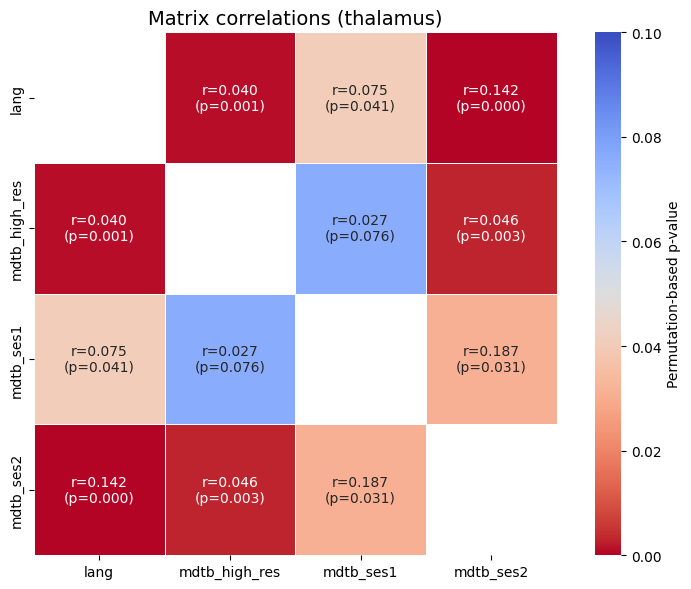

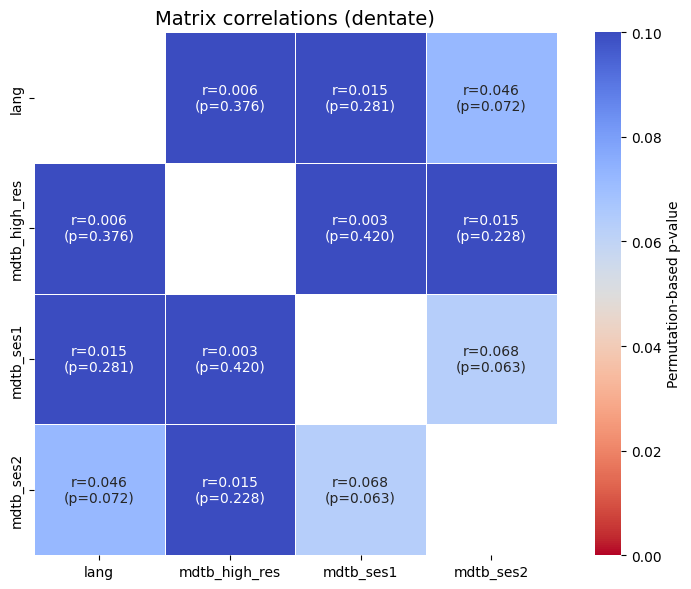

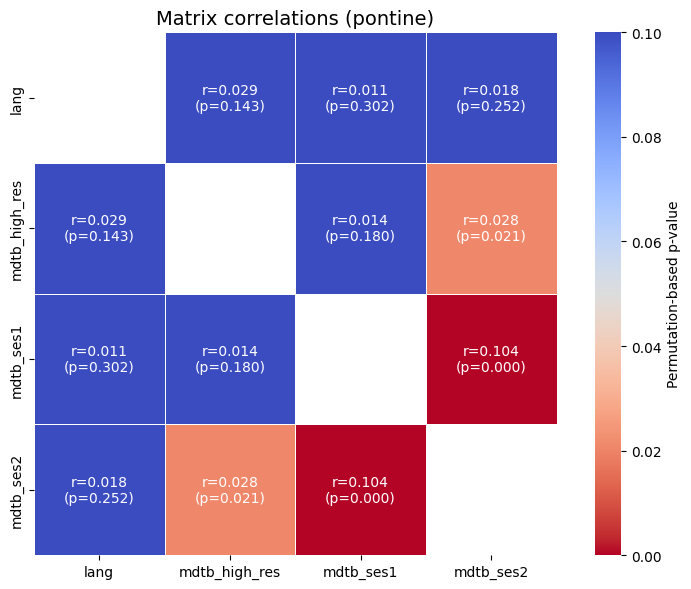

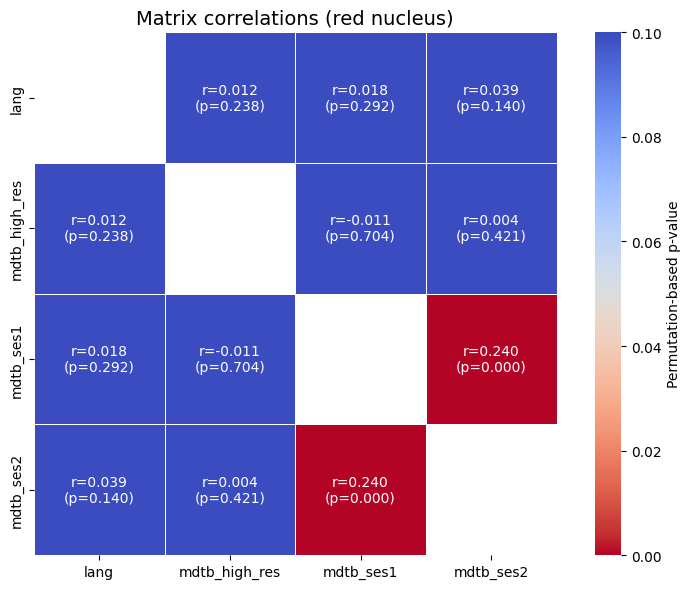

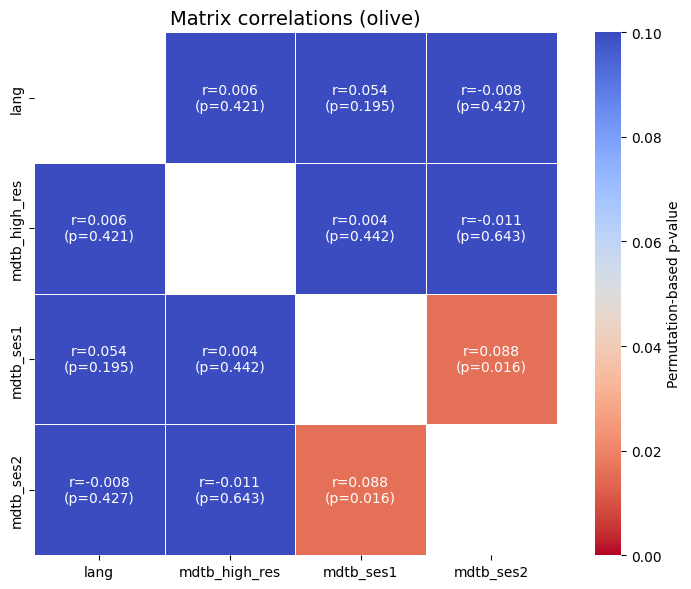

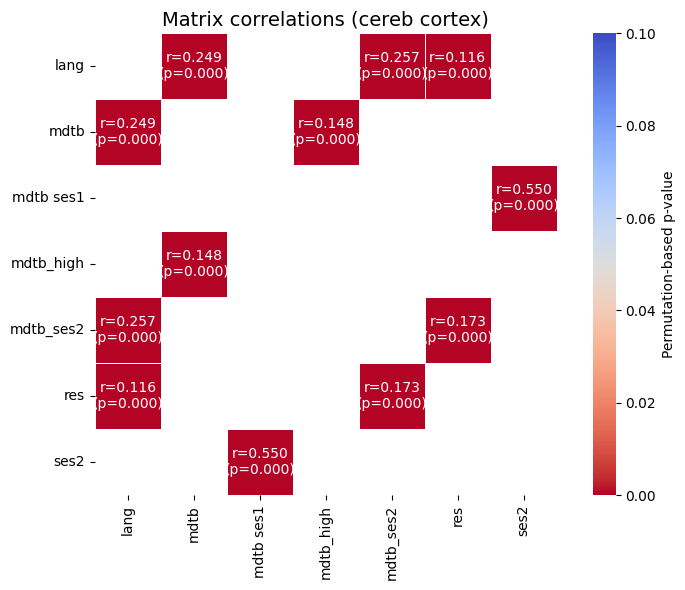

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import io

# --- Step 1: Read in the entire raw CSV as text ---
with open("correlation_results.csv", "r") as file:
    raw_text = file.read()

# --- Step 2: Split into ROI blocks using regex ---
blocks = re.split(r'\n(?=Comparison \()', raw_text)

roi_dataframes = {}

for block in blocks:
    lines = block.strip().split('\n')
    if not lines or len(lines) < 2:
        continue
    
    match = re.match(r'Comparison \((.+?)\)', lines[0])
    if match:
        roi_name = match.group(1).strip()
        csv_text = "\n".join(lines)
        df = pd.read_csv(io.StringIO(csv_text))
        roi_dataframes[roi_name] = df

# --- Step 3: Loop over each ROI and generate heatmap ---
for selected_roi, df in roi_dataframes.items():
    # Parse comparison names
    df["dataset1"] = df[df.columns[0]].str.extract(r'(\w+(?:[_\s]\w+)*) vs')[0]
    df["dataset2"] = df[df.columns[0]].str.extract(r'vs (\w+(?:[_\s]\w+)*)')[0]

    datasets = sorted(set(df["dataset1"]).union(df["dataset2"]))

    pval_matrix = pd.DataFrame(index=datasets, columns=datasets, dtype=float)
    annot_matrix = pd.DataFrame(index=datasets, columns=datasets, dtype=str)

    for _, row in df.iterrows():
        d1 = row["dataset1"]
        d2 = row["dataset2"]
        corr = float(row["original corr"])
        pval = float(row["permutation-based p-value"])
        text = f"r={corr:.3f}\n(p={pval:.3f})"
        
        pval_matrix.loc[d1, d2] = pval
        pval_matrix.loc[d2, d1] = pval
        annot_matrix.loc[d1, d2] = text
        annot_matrix.loc[d2, d1] = text

    for d in datasets:
        pval_matrix.loc[d, d] = None
        annot_matrix.loc[d, d] = "1.00\n(p=—)"

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sb.heatmap(
        pval_matrix,
        annot=annot_matrix,
        fmt="",
        cmap="coolwarm_r",  # red = more significant
        vmin=0, vmax=0.1,
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Permutation-based p-value"}
    )
    plt.title(f"Matrix correlations ({selected_roi})", fontsize=14)
    plt.tight_layout()
    plt.show()
